## Outline

This notebook is meant to detail setting up the MM/ML simulations 

## fitting the LJs terms

In [1]:
import mmml
import ase

import os
from pathlib import Path
import argparse
import sys
import numpy as np
import jax
import jax.numpy as jnp

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".45"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


# Setup: Mock CLI Arguments (following run_sim.py structure)

This cell creates a mock args object that mimics the CLI arguments from `run_sim.py`.
This allows the notebook to follow the same structure as the script.

In [91]:
# Import required modules (following run_sim.py structure)
from mmml.cli.base import (
    load_model_parameters,
    resolve_checkpoint_paths,
    setup_ase_imports,
    setup_mmml_imports,
)
from mmml.pycharmmInterface import import_pycharmm
import pycharmm
import pycharmm.ic as ic
import pycharmm.psf as psf
import pycharmm.energy as energy
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit
from mmml.pycharmmInterface.setupBox import setup_box_generic
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, coor
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

# Setup ASE imports
Atoms = setup_ase_imports()
CutoffParameters, ev2kcalmol, setup_calculator, get_ase_calc = setup_mmml_imports()

# Additional imports for simulation
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt

In [92]:
# ========================================================================
# MOCK CLI ARGUMENTS (spoofing run_sim.py CLI)
# ========================================================================
# Create a mock args object that mimics the CLI arguments from run_sim.py
# This allows the notebook to follow the same structure as the script

class MockArgs:
    """Mock CLI arguments following run_sim.py structure"""
    def __init__(self):
        # Paths
        self.pdbfile = None  # Will be created from valid_data if needed
        self.checkpoint = Path(RESTART) if 'RESTART' in globals() else None
        
        # System parameters
        self.n_monomers = 2
        self.n_atoms_monomer = 10
        self.atoms_per_monomer = 10  # Alias for compatibility
        
        # Calculator parameters
        self.ml_cutoff = 1.0
        self.mm_switch_on = 6.0
        self.mm_cutoff = 1.0
        self.include_mm = True
        self.skip_ml_dimers = False
        self.debug = True
        
        # MD simulation parameters
        self.temperature = 210.0
        self.timestep = 0.1
        self.nsteps_jaxmd = 100_000
        self.nsteps_ase = 10000
        self.ensemble = "nvt"
        self.heating_interval = 500
        self.write_interval = 100
        self.energy_catch = 0.5
        
        # Output
        self.output_prefix = "md_simulation"
        self.cell = None  # No PBC by default
        
        # Validation
        self.validate = False

# Create mock args object
args = MockArgs()

# Override with notebook-specific values if needed
if 'ATOMS_PER_MONOMER' in globals():
    args.n_atoms_monomer = ATOMS_PER_MONOMER
    args.atoms_per_monomer = ATOMS_PER_MONOMER
if 'N_MONOMERS' in globals():
    args.n_monomers = N_MONOMERS

print(f"Mock args created:")
print(f"  n_monomers: {args.n_monomers}")
print(f"  n_atoms_monomer: {args.n_atoms_monomer}")
print(f"  ml_cutoff: {args.ml_cutoff}")
print(f"  mm_switch_on: {args.mm_switch_on}")
print(f"  mm_cutoff: {args.mm_cutoff}")

Mock args created:
  n_monomers: 2
  n_atoms_monomer: 10
  ml_cutoff: 1.0
  mm_switch_on: 6.0
  mm_cutoff: 1.0


In [93]:
# System parameters (can be overridden by args)
ATOMS_PER_MONOMER = args.n_atoms_monomer
N_MONOMERS = args.n_monomers

# Load Data and Prepare Batches (following run_sim.py structure)

This cell loads the validation data and prepares batches that will be used to initialize simulations.
Note: The residue numbers in the PDB/PSF may need to be adjusted based on the actual system.

In [94]:
# ========================================================================
# LOAD DATA AND PREPARE BATCHES (following run_sim.py structure)
# ========================================================================

# Initialize random key for data loading
if 'data_key' not in globals():
    data_key = jax.random.PRNGKey(42)


data_file = "/pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz"

print(f"Loading data from: {data_file}")

# Prepare datasets
train_data, valid_data = prepare_datasets(
    data_key, 
    10500,  # num_train
    10500,  # num_valid
    [data_file], 
    natoms=ATOMS_PER_MONOMER * N_MONOMERS
)

# Prepare batches for validation data (used to initialize simulations)
valid_batches = prepare_batches_jit(data_key, valid_data, 1, num_atoms=ATOMS_PER_MONOMER * N_MONOMERS)
train_batches = prepare_batches_jit(data_key, train_data, 1, num_atoms=ATOMS_PER_MONOMER * N_MONOMERS)

print(f"Loaded {len(valid_data['R'])} validation samples")
print(f"Prepared {len(valid_batches)} validation batches")
print(f"Each batch contains {len(valid_batches[0]['R'])} atoms")

Loading data from: /pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz
dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)
Loaded 10500 validation samples
Prepared 10500 validation batches
Each batch contains 20 atoms


In [95]:
# Additional utility imports (if needed)
from ase.visualize.plot import plot_atoms

In [96]:
# Additional PyCHARMM imports (already imported in cell 3, but kept for reference)
from mmml.pycharmmInterface import setupRes, setupBox

In [97]:
# ========================================================================
# LOAD MODEL AND SETUP CALCULATOR (following run_sim.py structure)
# ========================================================================
uid = "test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94"
SCICORE = Path('/scicore/home/meuwly/boitti0000/')
SCICORE = Path("/pchem-data/meuwly/boittier/home/")
RESTART=str(SCICORE / "ckpts" / f"{uid}" / "epoch-5450" / "json_checkpoint")

# ========================================================================
# JSON-BASED CHECKPOINT LOADER (no orbax/pickle required)
# ========================================================================
def load_model_parameters_json(epoch_dir, natoms, use_orbax=False):
    """
    Load model parameters from checkpoint using JSON (no orbax/pickle required).
    
    This function tries to load checkpoints from JSON files first, then falls back
    to pickle if needed. JSON is preferred for portability.
    
    Args:
        epoch_dir: Path to checkpoint epoch directory
        natoms: Number of atoms
        use_orbax: If True, try orbax first (default: False)
    
    Returns:
        params, model: Model parameters and model instance
    """
    from mmml.physnetjax.physnetjax.models.model import EF
    import json
    import pickle
    
    epoch_dir = Path(epoch_dir)
    
    # Try orbax first if requested
    if use_orbax:
        try:
            from mmml.physnetjax.physnetjax.restart.restart import get_params_model
            params, model = get_params_model(str(epoch_dir), natoms=natoms)
            if model is not None:
                print("✓ Loaded checkpoint using orbax")
                return params, model
        except Exception as e:
            print(f"Warning: orbax loading failed: {e}")
            print("Falling back to JSON/pickle-based loading...")
    
    # Helper function to convert JSON-serialized arrays back to JAX arrays
    def json_to_jax(obj):
        """Recursively convert JSON lists to JAX arrays."""
        if isinstance(obj, dict):
            return {k: json_to_jax(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            # Check if it's a nested list (array)
            if len(obj) > 0 and isinstance(obj[0], (list, int, float)):
                arr = jnp.array(obj)
                return arr
            else:
                return [json_to_jax(item) for item in obj]
        elif isinstance(obj, (int, float)):
            return obj
        else:
            return obj
    
    # Try JSON-based loading first (preferred)
    json_candidates = [
        epoch_dir / "params.json",
        epoch_dir / "best_params.json",
        epoch_dir / "checkpoint.json",
        epoch_dir / "final_params.json",
    ]
    
    params = None
    params_source = None
    
    # Try JSON files first
    for json_path in json_candidates:
        if json_path.exists():
            print(f"Loading parameters from JSON: {json_path}")
            try:
                with open(json_path, 'r') as f:
                    checkpoint_data = json.load(f)
                
                # Extract params
                if isinstance(checkpoint_data, dict):
                    params_data = checkpoint_data.get('params') or checkpoint_data.get('ema_params') or checkpoint_data
                else:
                    params_data = checkpoint_data
                
                # Convert JSON arrays back to JAX arrays
                params = json_to_jax(params_data)
                params_source = "json"
                break
            except Exception as e:
                print(f"  Failed to load from {json_path}: {e}")
                continue
    
    # Fall back to pickle if JSON not found
    if params is None:
        pickle_candidates = [
            epoch_dir / "params.pkl",
            epoch_dir / "best_params.pkl",
            epoch_dir / "checkpoint.pkl",
            epoch_dir / "final_params.pkl",
        ]
        
        for pkl_path in pickle_candidates:
            if pkl_path.exists():
                print(f"Loading parameters from pickle: {pkl_path}")
                with open(pkl_path, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                
                # Extract params
                if isinstance(checkpoint_data, dict):
                    params = checkpoint_data.get('params') or checkpoint_data.get('ema_params') or checkpoint_data
                else:
                    params = checkpoint_data
                params_source = "pickle"
                break
    
    if params is None:
        all_candidates = [str(p) for p in json_candidates + [
            epoch_dir / "params.pkl",
            epoch_dir / "best_params.pkl",
            epoch_dir / "checkpoint.pkl",
            epoch_dir / "final_params.pkl",
        ]]
        raise FileNotFoundError(
            f"Could not find parameters in {epoch_dir}.\n"
            f"Tried JSON: {[str(p) for p in json_candidates]}\n"
            f"Tried pickle: {[str(p) for p in pickle_candidates if p.exists()]}\n"
            f"Please ensure checkpoint files exist."
        )
    
    # Load model config (prefer JSON)
    config_candidates = [
        epoch_dir / "model_config.json",
        epoch_dir.parent / "model_config.json",
        epoch_dir / "model_config.pkl",
        epoch_dir.parent / "model_config.pkl",
    ]
    
    model_kwargs = {}
    for config_path in config_candidates:
        if config_path.exists():
            print(f"Loading model config from: {config_path}")
            try:
                if config_path.suffix == '.json':
                    with open(config_path, 'r') as f:
                        model_kwargs = json.load(f)
                else:
                    with open(config_path, 'rb') as f:
                        model_kwargs = pickle.load(f)
                break
            except Exception as e:
                print(f"  Warning: Failed to load config from {config_path}: {e}")
                continue
    
    # If no config found, try to extract from checkpoint directory structure
    if not model_kwargs:
        print("Warning: No model config found, using defaults")
        # Try to infer from directory name or use defaults
        model_kwargs = {
            'features': 64,
            'cutoff': 8.0,
            'max_degree': 2,
            'num_iterations': 3,
        }
    
    # Set natoms
    model_kwargs['natoms'] = natoms
    
    # Create model
    model = EF(**model_kwargs)
    model.natoms = natoms
    
    print(f"✓ Loaded checkpoint using {params_source} (no orbax required)")
    print(f"  Model: {model}")
    
    return params, model

# Resolve checkpoint paths
if args.checkpoint is not None:
    base_ckpt_dir, epoch_dir = resolve_checkpoint_paths(args.checkpoint)
    print(f"Checkpoint base dir: {base_ckpt_dir}")
    print(f"Checkpoint epoch dir: {epoch_dir}")
else:
    # Fallback if RESTART is defined
    if 'RESTART' in globals():
        base_ckpt_dir = Path(RESTART)
        epoch_dir = base_ckpt_dir
    else:
        raise ValueError("Checkpoint path must be provided via args.checkpoint or RESTART variable")

# Load model parameters (using JSON-based loader to avoid orbax/pickle requirement)
natoms = ATOMS_PER_MONOMER * N_MONOMERS

# Try JSON-based loading first (preferred, no orbax/pickle required)
try:
    params, model = load_model_parameters_json(epoch_dir, natoms, use_orbax=False)
    print(f"Model loaded using JSON/pickle: {model}")
except Exception as e:
    print(f"JSON/pickle-based loading failed: {e}")
    print("Trying orbax-based loading (requires GPU environment)...")
    try:
        params, model = load_model_parameters(epoch_dir, natoms)
        model.natoms = natoms
        print(f"Model loaded using orbax: {model}")
    except Exception as e2:
        raise RuntimeError(
            f"Failed to load model with all methods:\n"
            f"  JSON/pickle: {e}\n"
            f"  Orbax: {e2}\n"
            f"Make sure checkpoint files exist in {epoch_dir}\n"
            f"Preferred format: JSON files (params.json, model_config.json)"
        )

# Setup calculator factory (following run_sim.py)
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER=args.n_atoms_monomer,
    N_MONOMERS=args.n_monomers,
    ml_cutoff_distance=args.ml_cutoff,
    mm_switch_on=args.mm_switch_on,
    mm_cutoff=args.mm_cutoff,
    doML=True,
    doMM=args.include_mm,
    doML_dimer=not args.skip_ml_dimers,
    debug=args.debug,
    model_restart_path=base_ckpt_dir,
    MAX_ATOMS_PER_SYSTEM=natoms,
    ml_energy_conversion_factor=1,
    ml_force_conversion_factor=1,
    cell=args.cell,
)

# Create cutoff parameters
CUTOFF_PARAMS = CutoffParameters(
    ml_cutoff=args.ml_cutoff,
    mm_switch_on=args.mm_switch_on,
    mm_cutoff=args.mm_cutoff,
)
print(f"Cutoff parameters: {CUTOFF_PARAMS}")

SystemExit: Checkpoint path must contain epoch-* subdirectories or point to an epoch directory.

/pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Fit Lennard-Jones Parameters to Training Data

Before running simulations, we can optimize the LJ parameters (epsilon and sigma scaling factors) to better match the training dataset. This fits only the MM part of the hybrid potential.
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:
# ========================================================================
# IMPORT OPTIMIZATION FUNCTIONS FROM UTILITY MODULE
# ========================================================================
# All optimization functions have been moved to mmml.utils.hybrid_optimization
# Import them here for use in the notebook

from mmml.utils.hybrid_optimization import (
    extract_lj_parameters_from_calculator,
    fit_hybrid_potential_to_training_data_jax,
    fit_lj_parameters_to_training_data_jax,
)

extract_lj_parameters_from_calculator?
fit_hybrid_potential_to_training_data_jax?

# Initialize Simulations from valid_data Batches

This section initializes simulations using positions and atomic numbers from `valid_data` batches.
Each batch can be used to create an ASE Atoms object and run a simulation.

In [10]:
# ========================================================================
# SETUP Pycharmm SYSTEM FIRST (required before MM contributions)
# ========================================================================
# IMPORTANT: PyCHARMM system must be initialized BEFORE creating calculators
# that use MM contributions, otherwise charges won't be available
#
# This generates residues in PyCHARMM and builds the structure.
# The atom ordering from PyCHARMM will be used to reorder valid_data batch atoms.

# Clear CHARMM state
# CLEAR_CHARMM()
# reset_block()

                                                                                                                                                                                                    # Generate residues in PyCHARMM
# For N_MONOMERS=2, we generate "ACO ACO" (two acetone molecules)
# Adjust the residue string based on N_MONOMERS and your system
residue_string = " ".join(["ACO"] * N_MONOMERS)
print(f"Generating {N_MONOMERS} residues: {residue_string}")

try:
    # Generate residues (this creates the PSF structure)
    setupRes.generate_residue(residue_string)
    print("Residues generated successfully")
    
    # Build the structure using internal coordinates
    ic.build()
    print("Structure built using internal coordinates")
    
    # Show coordinates
    coor.show()
    
    # Get PyCHARMM atom ordering information
    # This will be used to reorder valid_data batch atoms
    pycharmm_atypes = np.array(psf.get_atype())[:N_MONOMERS * ATOMS_PER_MONOMER]
    pycharmm_resids = np.array(psf.get_res())[:N_MONOMERS * ATOMS_PER_MONOMER]
    pycharmm_iac = np.array(psf.get_iac())[:N_MONOMERS * ATOMS_PER_MONOMER]
    
    print(f"PyCHARMM atom types: {pycharmm_atypes}")
    print(f"PyCHARMM residue IDs: {pycharmm_resids}")
    print(f"PyCHARMM has {len(pycharmm_atypes)} atoms")
    
    # View PyCHARMM state
    mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()
    
except Exception as e:
    print(f"Warning: Could not initialize PyCHARMM system: {e}")
    print("You may need to adjust residue names/numbers")
    print("MM contributions will be disabled if PyCHARMM is not initialized")
    if args.include_mm:
        print("Setting include_mm=False since PyCHARMM initialization failed")
        args.include_mm = False
    pycharmm_atypes = None
    pycharmm_resids = None
    pycharmm_iac = None

Generating 2 residues: ACO ACO
***** Generating residue *****
  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     

In [11]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [98]:
Z, R = valid_data["Z"][10], valid_data["R"][10]

ase_atoms = ase.Atoms(Z,R)
import pandas as pd
from ase.visualize import view as view_atoms
view_atoms(ase_atoms, viewer="x3d")

In [99]:
R_ = R.copy()
R

array([[  7.922,   5.02 ,  -9.542],
       [  8.526,   3.648,  -9.424],
       [  6.648,   5.266,  -8.862],
       [  8.48 ,   5.822, -10.346],
       [  6.784,   5.906,  -7.999],
       [  6.205,   4.297,  -8.692],
       [  5.891,   5.592,  -9.532],
       [  7.764,   2.939,  -9.022],
       [  9.562,   3.678,  -8.943],
       [  8.874,   3.285, -10.396],
       [  8.94 ,  11.966, -10.661],
       [  8.71 ,  10.69 ,  -9.829],
       [  8.345,  12.075, -12.045],
       [  9.692,  12.82 , -10.2  ],
       [  8.923,  11.549, -12.802],
       [  8.29 ,  13.169, -12.329],
       [  7.384,  11.63 , -12.08 ],
       [  9.226,   9.812, -10.372],
       [  7.647,  10.496,  -9.787],
       [  9.117,  10.915,  -8.88 ]])

In [100]:
coor.set_positions(pd.DataFrame(R, columns=["x", "y", "z"]))
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [101]:
pycharmm_atypes = psf.get_atype()
pycharmm_resids = np.array(psf.get_resid())

In [102]:
pycharmm_atypes, pycharmm_resids

(['O1',
  'C1',
  'C2',
  'C3',
  'H21',
  'H22',
  'H23',
  'H31',
  'H32',
  'H33',
  'O1',
  'C1',
  'C2',
  'C3',
  'H21',
  'H22',
  'H23',
  'H31',
  'H32',
  'H33'],
 array(['1', '2'], dtype='<U1'))

In [103]:
_ = coor.show()
_


          COORDINATE FILE MODULE
        20  EXT
         1         1  ACO       O1              7.9220000000        5.0200000000       -9.5420000000  ACO ACO   1               0.0000000000
         2         1  ACO       C1              8.5260000000        3.6480000000       -9.4240000000  ACO ACO   1               0.0000000000
         3         1  ACO       C2              6.6480000000        5.2660000000       -8.8620000000  ACO ACO   1               0.0000000000
         4         1  ACO       C3              8.4800000000        5.8220000000      -10.3460000000  ACO ACO   1               0.0000000000
         5         1  ACO       H21             6.7840000000        5.9060000000       -7.9990000000  ACO ACO   1               0.0000000000
         6         1  ACO       H22             6.2050000000        4.2970000000       -8.6920000000  ACO ACO   1               0.0000000000
         7         1  ACO       H23             5.8910000000        5.5920000000       -9.5320000000  AC

1

In [104]:
from mmml.pycharmmInterface.import_pycharmm import reset_block, pycharmm, reset_block_no_internal, pycharmm_quiet, pycharmm_verbose
reset_block()
reset_block_no_internal()
reset_block()
nbonds = """!#########################################
! Bonded/Non-bonded Options & Constraints
!#########################################

! Non-bonding parameters
nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
vswitch NBXMOD 3 -
inbfrq -1 imgfrq -1
"""
pycharmm.lingo.charmm_script(nbonds)


1

In [105]:
pycharmm_quiet()

In [106]:
def test_configuration(reordered):
    coor.set_positions(pd.DataFrame(R[reordered], columns=["x", "y", "z"]))
    coor.get_positions()
    # energy.show()
    energy_df = energy.get_energy()
    return float(energy_df[["IMPR", "ANGL", "BOND", "UREY", "DIHE"]].to_numpy().sum())

import itertools

# Example: 20-atom array = first 10 in block A, next 10 in block B
atoms = list(range(20))  # replace with your actual atom indices / objects

n = 10  # size of each block
block1 = atoms[:n]
block2 = atoms[n:2*n]
res = []

    

In [107]:
test_configuration(np.arange(20))

9478.538335077

In [108]:

# min_res = 10000000
# reordered_found = None
# for perm in itertools.permutations(range(n)):
#     # Apply the same permutation to both blocks
#     new_block1 = [block1[i] for i in perm]
#     new_block2 = [block2[i] for i in perm]

#     # Recombine into a 20-length array
#     reordered = new_block1 + new_block2
#     res = test_configuration(reordered)
#     # print(res)
#     if min_res > res:
#         reordered_found = reordered
#         min_res = res
    # min_res, reordered_found
# reordered_found

In [109]:
def val_configuration(reordered):
    coor.set_positions(pd.DataFrame(R[reordered], columns=["x", "y", "z"]))
    coor.get_positions()
    # energy.show()
    energy_df = energy.get_energy()
    return energy_df[["IMPR", "ANGL", "BOND", "UREY", "DIHE"]]

In [110]:
val_configuration(np.arange(20))

,IMPR,ANGL,BOND,UREY,DIHE
0,0.848994,1974.111233,7501.898513,0.591863,1.087733


In [111]:
Z

array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1])

In [112]:
pycharmm_atypes

['O1',
 'C1',
 'C2',
 'C3',
 'H21',
 'H22',
 'H23',
 'H31',
 'H32',
 'H33',
 'O1',
 'C1',
 'C2',
 'C3',
 'H21',
 'H22',
 'H23',
 'H31',
 'H32',
 'H33']

In [113]:
final_reorder = [3, 0, 1, 2, 7, 8, 9, 4, 5, 6, 
                 13, 10, 11, 12, 17, 18, 19, 14, 15, 16]
final_reorder

val_configuration(final_reorder)

,IMPR,ANGL,BOND,UREY,DIHE
0,0.581989,9.663635,6.617427,0.591863,1.256935


In [114]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

# Setup PyCHARMM System (REQUIRED before MM contributions)

**IMPORTANT**: The PyCHARMM system must be initialized BEFORE creating calculators that use MM contributions. 

This cell:
1. Generates residues using `setupRes.generate_residue()` (e.g., "ACO ACO" for two acetone molecules)
2. Builds the structure using `ic.build()`
3. Gets the atom ordering from PyCHARMM

**Note on atom reordering**: The atoms from `valid_data` batches may need to be reordered to match PyCHARMM's atom ordering. 
The `reorder_atoms_to_match_pycharmm()` function handles this, but you may need to customize it based on your system.

- Residue names (e.g., "ACO" for acetone) must match your system
- The number of residues should match `N_MONOMERS`
- If PyCHARMM initialization fails, MM contributions will be automatically disabled

# Initialize Multiple Simulations from valid_data Batches

This cell demonstrates how to initialize multiple simulations from different batches.
Each simulation can be run independently.

In [115]:
from mmml.utils.simulation_utils import (
    reorder_atoms_to_match_pycharmm,
    initialize_simulation_from_batch,
    initialize_multiple_simulations,
)
# initialize_simulation_from_batch?
# Initialize first simulation from batch 0
# atoms, hybrid_calc = initialize_simulation_from_batch(valid_batches[0], calculator_factory, CUTOFF_PARAMS, args)

In [116]:
# Step 1: Extract base LJ parameters (do this once, after calculator_factory is created)
lj_params = extract_lj_parameters_from_calculator(ATOMS_PER_MONOMER=10, N_MONOMERS=2 )
lj_params


 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000


{'atc_epsilons': array([-0.035, -0.06 , -0.055, -0.12 ]),
 'atc_rmins': array([1.34 , 1.8  , 2.175, 1.7  ]),
 'atc_qs': array([ 0.09 ,  0.14 , -0.1  , -0.562]),
 'at_codes': array([3, 1, 2, 2, 0, 0, 0, 0, 0, 0, 3, 1, 2, 2, 0, 0, 0, 0, 0, 0]),
 'pair_idx_atom_atom': array([[ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16],
        [ 0, 17],
        [ 0, 18],
        [ 0, 19],
        [ 1, 10],
        [ 1, 11],
        [ 1, 12],
        [ 1, 13],
        [ 1, 14],
        [ 1, 15],
        [ 1, 16],
        [ 1, 17],
        [ 1, 18],
        [ 1, 19],
        [ 2, 10],
        [ 2, 11],
        [ 2, 12],
        [ 2, 13],
        [ 2, 14],
        [ 2, 15],
        [ 2, 16],
        [ 2, 17],
        [ 2, 18],
        [ 2, 19],
        [ 3, 10],
        [ 3, 11],
        [ 3, 12],
        [ 3, 13],
        [ 3, 14],
        [ 3, 15],
        [ 3, 16],
        [ 3, 17],
        [ 3, 18],
        [ 3, 19],
        [ 4, 10

In [117]:
# Prepare batches for validation data (used to initialize simulations)
valid_batches = prepare_batches_jit(data_key, valid_data, 1, num_atoms=ATOMS_PER_MONOMER * N_MONOMERS)
train_batches = prepare_batches_jit(data_key, train_data, 1, num_atoms=ATOMS_PER_MONOMER * N_MONOMERS)

In [118]:
type(train_batches)

list

In [119]:
train_batches_copy = train_batches.copy()

In [120]:
for i in range(len(train_batches)):
    train_batches_copy[i]["R"] = train_batches[i]["R"][final_reorder]
    train_batches_copy[i]["Z"] = train_batches[i]["Z"][final_reorder]
    train_batches_copy[i]["F"] = train_batches[i]["F"][final_reorder]

In [121]:
# ========================================================================
# MODE 1: Optimize LJ parameters only
# ========================================================================
print("=" * 60)
print("MODE 1: Optimizing LJ parameters only")
print("=" * 60)

result_lj = fit_hybrid_potential_to_training_data_jax(
    train_batches=train_batches_copy,
    base_calculator_factory=calculator_factory,
    model=model,
    model_params=params,
    atc_epsilons=lj_params["atc_epsilons"],
    atc_rmins=lj_params["atc_rmins"],
    atc_qs=lj_params["atc_qs"],
    at_codes=lj_params["at_codes"],
    pair_idx_atom_atom=lj_params["pair_idx_atom_atom"],
    cutoff_params=CUTOFF_PARAMS,  # Optional
    args=args,  # Optional
    optimize_mode="lj_only",
    n_samples=20,
    energy_weight=1.0,
    force_weight=1.0,
    learning_rate=0.01,
    n_iterations=100,
    verbose=True
)

opt_ep_scale_lj = result_lj["ep_scale"]
opt_sig_scale_lj = result_lj["sig_scale"]



MODE 1: Optimizing LJ parameters only
Fitting hybrid potential using 20 training samples
  Optimization mode: lj_only
  Number of atom types: 4
  Initial ep_scale: [1. 1. 1. 1.]
  Initial sig_scale: [1. 1. 1. 1.]
  Energy weight: 1.0, Force weight: 1.0
  Learning rate: 0.01, Iterations: 100
  Precomputing ML contributions (constant for LJ-only optimization)...
  ✓ ML contributions precomputed for 20 configurations

Starting JAX optimization (mode: lj_only)...
  Iteration    0: Loss = 6382.645020
    ep_scale: [1.01 1.01 1.01 1.01]
    sig_scale: [0.99000007 1.01       0.99000007 0.99000007]
  Iteration   10: Loss = 6367.073730
    ep_scale: [1.1110187 1.1103629 1.1108844 1.1116776]
    sig_scale: [0.9230327  1.1104144  0.92337954 0.9080296 ]
  Iteration   20: Loss = 6358.504395
    ep_scale: [1.2133163 1.2132229 1.2125823 1.216146 ]
    sig_scale: [0.94466966 1.209278   0.9434072  0.87979877]
  Iteration   30: Loss = 6352.764648
    ep_scale: [1.3170346 1.31931   1.3149633 1.3207719]
 

In [122]:
opt_ep_scale_lj, opt_sig_scale_lj

(Array([2.0252774, 2.0390651, 2.0136483, 2.0324636], dtype=float32),
 Array([0.9526447 , 1.2604363 , 0.94113445, 0.88508296], dtype=float32))

In [123]:
result_lj

{'loss_history': [6382.64501953125,
  6379.32763671875,
  6376.60546875,
  6374.412109375,
  6372.66748046875,
  6371.2880859375,
  6370.1875,
  6369.28369140625,
  6368.50244140625,
  6367.78125,
  6367.07373046875,
  6366.3486328125,
  6365.5849609375,
  6364.77490234375,
  6363.92041015625,
  6363.02880859375,
  6362.109375,
  6361.17919921875,
  6360.25732421875,
  6359.35986328125,
  6358.50439453125,
  6357.705078125,
  6356.97265625,
  6356.31103515625,
  6355.716796875,
  6355.181640625,
  6354.68701171875,
  6354.21533203125,
  6353.74658203125,
  6353.2666015625,
  6352.7646484375,
  6352.24072265625,
  6351.69775390625,
  6351.14306640625,
  6350.5849609375,
  6350.03173828125,
  6349.48583984375,
  6348.951171875,
  6348.4248046875,
  6347.90478515625,
  6347.3857421875,
  6346.86181640625,
  6346.33154296875,
  6345.7958984375,
  6345.2509765625,
  6344.7021484375,
  6344.1513671875,
  6343.60400390625,
  6343.0634765625,
  6342.5322265625,
  6342.009765625,
  6341.4975585

In [127]:
# # ========================================================================
# # Use optimized parameters in subsequent calculations
# # ========================================================================
# # For LJ-only optimization:
from mmml.utils.hybrid_optimization import expand_scaling_parameters_to_full_set
# Expand to full parameter set
full_ep_scale, full_sig_scale = expand_scaling_parameters_to_full_set(
   opt_ep_scale_lj, opt_sig_scale_lj, lj_params
)  # Shape: (163,) - all types


In [128]:
# # ========================================================================
# # MODE 2: Optimize ML parameters only
# # ========================================================================
# print("\n" + "=" * 60)
# print("MODE 2: Optimizing ML parameters only")
# print("=" * 60)

# result_ml = fit_hybrid_potential_to_training_data_jax(
#     train_batches=train_batches_copy,
#     base_calculator_factory=calculator_factory,
#     model=model,
#     model_params=params,
#     atc_epsilons=lj_params["atc_epsilons"],
#     atc_rmins=lj_params["atc_rmins"],
#     atc_qs=lj_params["atc_qs"],
#     at_codes=lj_params["at_codes"],
#     pair_idx_atom_atom=lj_params["pair_idx_atom_atom"],
#     optimize_mode="ml_only",
#     n_samples=20,
#     energy_weight=1.0,
#     force_weight=1.0,
#     learning_rate=0.001,  # Lower LR for ML params
#     n_iterations=100,
#     verbose=True
# )

# opt_ml_params = result_ml["ml_params"]



In [129]:
# # ========================================================================
# # MODE 3: Optimize both ML and LJ parameters together
# # ========================================================================
# print("\n" + "=" * 60)
# print("MODE 3: Optimizing both ML and LJ parameters together")
# print("=" * 60)

# result_both = fit_hybrid_potential_to_training_data_jax(
#     train_batches=train_batches_copy,
#     base_calculator_factory=calculator_factory,
#     model=model,
#     model_params=params,
#     atc_epsilons=lj_params["atc_epsilons"],
#     atc_rmins=lj_params["atc_rmins"],
#     atc_qs=lj_params["atc_qs"],
#     at_codes=lj_params["at_codes"],
#     pair_idx_atom_atom=lj_params["pair_idx_atom_atom"],
#     optimize_mode="both",
#     n_samples=20,
#     energy_weight=1.0,
#     force_weight=1.0,
#     learning_rate=0.01,
#     n_iterations=100,
#     verbose=True
# )

# opt_ml_params_both = result_both["ml_params"]
# opt_ep_scale_both = result_both["ep_scale"]
# opt_sig_scale_both = result_both["sig_scale"]



In [130]:
result = fit_hybrid_potential_to_training_data_jax(
    train_batches=train_batches_copy,
    base_calculator_factory=calculator_factory,
    model=model,
    model_params=params,
    atc_epsilons=full_ep_scale,
    atc_rmins=full_sig_scale,
    atc_qs=lj_params["atc_qs"],
    at_codes=lj_params["at_codes"],
    pair_idx_atom_atom=lj_params["pair_idx_atom_atom"],
    cutoff_params=CUTOFF_PARAMS,
    optimize_mode="cutoff_only",
    initial_ml_cutoff=1.0,  # optional
    initial_mm_switch_on=6.0,  # optional
    initial_mm_cutoff=1.0,  # optional
    n_samples=20,
    learning_rate=0.01,
    n_iterations=100,
    verbose=True
)

Fitting hybrid potential using 20 training samples
  Optimization mode: cutoff_only
  Number of atom types: 163
  Initial ml_cutoff: 1.0
  Initial mm_switch_on: 6.0
  Initial mm_cutoff: 1.0
  Energy weight: 1.0, Force weight: 1.0
  Learning rate: 0.01, Iterations: 100

Starting JAX optimization (mode: cutoff_only)...
  Iteration    0: Loss = 6376.222168
    ml_cutoff: 1.0000 (grad: 0.000000e+00)
    mm_switch_on: 5.9900 (grad: 1.092610e+01)
    mm_cutoff: 0.9900 (grad: 4.739999e+00)
  Iteration   10: Loss = 6374.462891
    ml_cutoff: 1.0000 (grad: 0.000000e+00)
    mm_switch_on: 5.8892 (grad: 1.361072e+01)
    mm_cutoff: 0.8892 (grad: 5.865635e+00)
  Iteration   20: Loss = 6372.230469
    ml_cutoff: 1.0000 (grad: 0.000000e+00)
    mm_switch_on: 5.7849 (grad: 1.625212e+01)
    mm_cutoff: 0.7847 (grad: 7.324403e+00)
  Iteration   30: Loss = 6369.396973
    ml_cutoff: 1.0000 (grad: 0.000000e+00)
    mm_switch_on: 5.6759 (grad: 1.832153e+01)
    mm_cutoff: 0.6735 (grad: 9.320163e+00)
  Ite

In [131]:
# result

In [132]:
CUTOFF_PARAMS = CutoffParameters(ml_cutoff=result["ml_cutoff"], mm_switch_on=result["mm_switch_on"], mm_cutoff=result["mm_cutoff"])

In [133]:


calculator_factory_lj_optimized = setup_calculator(
    ATOMS_PER_MONOMER=args.n_atoms_monomer,
    N_MONOMERS=args.n_monomers,
    ml_cutoff_distance=result["ml_cutoff"],
    mm_switch_on=result["mm_switch_on"],
    mm_cutoff=result["mm_cutoff"],
    doML=True,
    doMM=args.include_mm,
    doML_dimer=not args.skip_ml_dimers,
    debug=True,
    model_restart_path=base_ckpt_dir,
    MAX_ATOMS_PER_SYSTEM=natoms,
    ml_energy_conversion_factor=1,
    ml_force_conversion_factor=1,
    cell=args.cell,
    ep_scale=np.array(full_ep_scale),
    sig_scale=np.array(full_sig_scale),
)


[setup_calculator] Cutoff inputs -> ml_cutoff_distance=1.0000, mm_switch_on=4.8796, mm_cutoff=0.1000
[setup_calculator] CutoffParameters stored -> ml_cutoff=1.0000, mm_switch_on=4.8796, mm_cutoff=0.1000
0 1
unique_res_ids [0, 1]
len(dimer_perms) 1
✓ Loaded checkpoint from /pchem-data/meuwly/boittier/home/ckpts/test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94/epoch-5450/json_checkpoint


In [134]:
initialize_simulation_from_batch?

Signature:
initialize_simulation_from_batch(
    batch: dict,
    calculator_factory,
    cutoff_params,
    args,
    pycharmm_atypes: Optional[numpy.ndarray] = None,
    pycharmm_resids: Optional[numpy.ndarray] = None,
    ATOMS_PER_MONOMER: Optional[int] = None,
    N_MONOMERS: Optional[int] = None,
) -> Tuple[ase.atoms.Atoms, <built-in function any>]
Docstring:
Initialize a simulation from a valid_data batch.

Args:
    batch: Dictionary containing 'R' and 'Z' keys (from valid_batches)
    calculator_factory: Calculator factory function (from setup_calculator)
    cutoff_params: Cutoff parameters
    args: Arguments object (for calculator factory calls)
    pycharmm_atypes: Atom types from PyCHARMM PSF (optional, for reordering)
    pycharmm_resids: Residue IDs from PyCHARMM PSF (optional, for reordering)
    ATOMS_PER_MONOMER: Number of atoms per monomer (optional, for reordering)
    N_MONOMERS: Number of monomers (optional, for reordering)

Returns:
    atoms: ASE Atoms object i

In [137]:
from mmml.utils.simulation_utils import (
    reorder_atoms_to_match_pycharmm,
    initialize_simulation_from_batch,
    initialize_multiple_simulations,
)
# initialize_simulation_from_batch?
# Initialize first simulation from batch 0
atoms, hybrid_calc = initialize_simulation_from_batch(train_batches_copy[0], calculator_factory_lj_optimized, None , args)

Initializing simulation from batch
  Positions shape: (20, 3)
  Atomic numbers shape: (20,)
  Number of atoms: 20
  PyCHARMM is responsive
  Retrieved PyCHARMM atom types and residue IDs from PSF
  Attempting to reorder atoms to match PyCHARMM ordering...
    ATOMS_PER_MONOMER: 10, N_MONOMERS: 2
    PyCHARMM atom types shape: (20,)
  Reordering atoms to match PyCHARMM ordering...
  Original R shape: (20, 3), Z shape: (20,)
  Trying 6 different atom orderings...
  Set initial coordinates from batch data
  Using energy term 'IMPR' for reordering evaluation
  (Also available: BOND, DIHE)
    Ordering 1/6: IMPR=0.039709 BOND=6.717323 DIHE=0.927939 kcal/mol
    Ordering 2/6: IMPR=0.063852 BOND=3186.189432 DIHE=0.829066 kcal/mol
    Ordering 3/6: IMPR=0.040982 BOND=3161.011574 DIHE=1.324883 kcal/mol
    Ordering 4/6: IMPR=0.065124 BOND=6340.483684 DIHE=1.226010 kcal/mol
    Ordering 5/6: IMPR=14.582096 BOND=1104.804740 DIHE=0.889812 kcal/mol
    Ordering 6/6: IMPR=38.323893 BOND=959.215064 D

In [138]:
dir(args)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'atoms_per_monomer',
 'cell',
 'checkpoint',
 'debug',
 'energy_catch',
 'ensemble',
 'heating_interval',
 'include_mm',
 'ml_cutoff',
 'mm_cutoff',
 'mm_switch_on',
 'n_atoms_monomer',
 'n_monomers',
 'nsteps_ase',
 'nsteps_jaxmd',
 'output_prefix',
 'pdbfile',
 'skip_ml_dimers',
 'temperature',
 'timestep',
 'validate',
 'write_interval']

In [139]:
hybrid_calc.verbose = True
atoms.calc = hybrid_calc

In [140]:
?hybrid_calc

Type:           AseDimerCalculator
String form:    <mmml.pycharmmInterface.mmml_calculator.setup_calculator.<locals>.AseDimerCalculator object at 0x148834db6f30>
File:           ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Docstring:      ASE calculator implementation for dimer calculations
Init docstring:
Initialize calculator with configuration parameters

Args:
    verbose: If True, store full ModelOutput breakdown (ml_2b_E/F, mm_E/F, etc.) 
             in self.results for analysis/testing. Adds overhead.

sssss
sssss
sssss
sssss
sssss
sssss
sssss
sssss
sssss


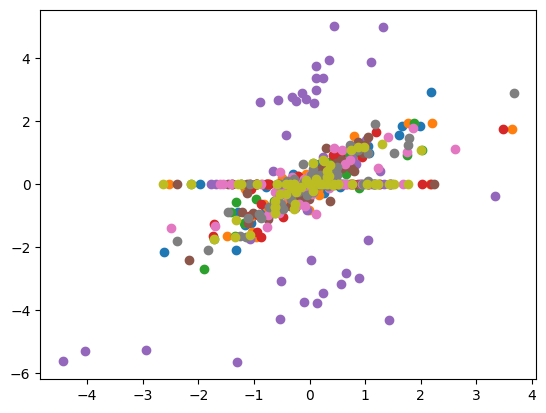

In [141]:
import matplotlib.pyplot as plt

for b in train_batches_copy[:10]:
    if b["N"] == 20:
        atoms.set_positions(b["R"])
        f_true, f_calc = b["F"], atoms.get_forces()
        # print(f_true)
        # print(f_calc)
        # print(f_true - f_calc)
        print("sssss")
        plt.scatter(f_true.flatten(), f_calc.flatten())

plt.show()

In [142]:
atoms.calc.results

{'model_output': {},
 'energy': Array(-64.648926, dtype=float32),
 'forces': Array([[-0.71762925, -0.08660138, -0.31844556],
        [ 0.76310074, -0.15971664,  0.40853748],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-1.6944325 ,  1.2668431 ,  0.26827264],
        [ 0.5993326 , -0.21707736, -1.6201215 ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.8049928 , -1.1397614 ,  0.11864373],
        [ 0.        ,  0.        ,  0.        ],
        [ 1.1810658 ,  1.0873919 , -0.74567163],
        [ 0.6674055 , -0.54327714, -0.6365597 ],
        [ 1.0789771 , -0.03407246, -0.13471514],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.25421327, -0.9130758 ,  1.1870487 ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.09665769,  0.73745537,  0.1546

In [143]:
atoms.get_forces()

Array([[-0.71762925, -0.08660138, -0.31844556],
       [ 0.76310074, -0.15971664,  0.40853748],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.6944325 ,  1.2668431 ,  0.26827264],
       [ 0.5993326 , -0.21707736, -1.6201215 ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.8049928 , -1.1397614 ,  0.11864373],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.1810658 ,  1.0873919 , -0.74567163],
       [ 0.6674055 , -0.54327714, -0.6365597 ],
       [ 1.0789771 , -0.03407246, -0.13471514],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.25421327, -0.9130758 ,  1.1870487 ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.09665769,  0.73745537,  0.15468824],
       [ 0.21288005, -1.7448912 , -0.33172998]], dtype=float32)

In [83]:
atoms.get_atomic_numbers()

array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1])

In [84]:
pycharmm_atypes

['O1',
 'C1',
 'C2',
 'C3',
 'H21',
 'H22',
 'H23',
 'H31',
 'H32',
 'H33',
 'O1',
 'C1',
 'C2',
 'C3',
 'H21',
 'H22',
 'H23',
 'H31',
 'H32',
 'H33']

In [85]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [65]:
initialize_multiple_simulations?

Signature:
initialize_multiple_simulations(
    valid_batches: list,
    calculator_factory,
    cutoff_params,
    args,
    n_simulations: int = 5,
    pycharmm_atypes: Optional[numpy.ndarray] = None,
    pycharmm_resids: Optional[numpy.ndarray] = None,
    ATOMS_PER_MONOMER: Optional[int] = None,
    N_MONOMERS: Optional[int] = None,
) -> list
Docstring:
Initialize multiple simulations from different valid_data batches.

Args:
    valid_batches: List of batch dictionaries (from prepare_batches_jit)
    calculator_factory: Calculator factory function (from setup_calculator)
    cutoff_params: Cutoff parameters
    args: Arguments object (for calculator factory calls)
    n_simulations: Number of simulations to initialize (default: 5)
    pycharmm_atypes: Atom types from PyCHARMM PSF (optional, for reordering)
    pycharmm_resids: Residue IDs from PyCHARMM PSF (optional, for reordering)
    ATOMS_PER_MONOMER: Number of atoms per monomer (optional, for reordering)
    N_MONOMERS: Numbe

In [85]:
# Initialize multiple simulations
# Adjust n_simulations as needed
simulations = initialize_multiple_simulations(train_batches_copy[:2], calculator_factory_lj_optimized, CUTOFF_PARAMS, args)
print(f"\nInitialized {len(simulations)} simulations from valid_data batches")

Initializing simulation from batch
  Positions shape: (20, 3)
  Atomic numbers shape: (20,)
  Number of atoms: 20
  PyCHARMM is responsive
  Retrieved PyCHARMM atom types and residue IDs from PSF
  Attempting to reorder atoms to match PyCHARMM ordering...
    ATOMS_PER_MONOMER: 10, N_MONOMERS: 2
    PyCHARMM atom types shape: (20,)
  Reordering atoms to match PyCHARMM ordering...
  Original R shape: (20, 3), Z shape: (20,)
  Trying 6 different atom orderings...
  Set initial coordinates from batch data
  Using energy term 'IMPR' for reordering evaluation
  (Also available: BOND, DIHE)
    Ordering 1/6: IMPR=0.039709 BOND=6.717323 DIHE=0.927939 kcal/mol
    Ordering 2/6: IMPR=0.063852 BOND=3186.189432 DIHE=0.829066 kcal/mol
    Ordering 3/6: IMPR=0.040982 BOND=3161.011574 DIHE=1.324883 kcal/mol
    Ordering 4/6: IMPR=0.065124 BOND=6340.483684 DIHE=1.226010 kcal/mol
    Ordering 5/6: IMPR=14.582096 BOND=1104.804740 DIHE=0.889812 kcal/mol
    Ordering 6/6: IMPR=38.323893 BOND=959.215064 D

Traceback (most recent call last):
  File "/pchem-data/meuwly/boittier/home/mmml/mmml/utils/simulation_utils.py", line 574, in initialize_simulation_from_batch
    hybrid_energy = float(atoms.get_potential_energy())
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ase/atoms.py", line 835, in get_potential_energy
    energy = self._calc.get_potential_energy(self)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ase/calculators/abc.py", line 26, in get_potential_energy
    return self.get_property(name, atoms)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ase/calculators/calculator.py", line 519, in get_property
    self.calculate(atoms, [name], system_changes)
  File "/pchem-data/meuwly/boittier/home/mmml/mmml/pycharmmInterface/mmml_calculator.py", line 16

# Example: Run a Simple Energy Calculation

This demonstrates how to use the initialized simulations.

In [92]:
                # ========================================================================
# EXAMPLE: RUN ENERGY CALCULATIONS
# ========================================================================

# Example: Calculate energy for the first simulation
if len(simulations) > 0:
    atoms_example, calc_example = simulations[0]
    _energy = atoms_example.get_potential_energy()
    _forces = atoms_example.get_forces()
    print(f"Example simulation energy: {_energy:.6f} eV")
    print(f"Example simulation forces shape: {_forces.shape}")
    print(f"Max force magnitude: {np.abs(_forces).max():.6f} eV/Å")
else:
    print("No simulations initialized. Check batch data and system parameters.")

No simulations initialized. Check batch data and system parameters.


In [68]:
from ase.visualize import view
view(atoms_example, viewer="x3d")

In [69]:
forces

Array([[-0.77742296,  0.6827544 , -0.1022442 ],
       [ 0.6947665 , -0.94786   , -0.8985358 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.07586901, -0.05301681, -0.29063153],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.09218006,  0.03094792,  0.4335372 ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.15781285,  0.14848545, -0.6789729 ],
       [-0.27007565, -0.46399748,  1.2189962 ],
       [ 0.78182304, -0.6865988 , -0.01179719],
       [-0.08742553,  0.62157786, -1.3105353 ],
       [-0.09730127,  0.99524426, -2.090323  ],
       [-2.1488578 , -0.72964394,  2.9129624 ],
       [-0.68232507, -1.0814397 ,  0.3325614 ],
       [-1.2308909 , -0.74783444,  1.2137635 ],
       [ 1.8443935 ,  0.571167  ,  0.31756997],
       [ 1.8548793 ,  1.5693676 , -0.8140422 ],
       [ 0.19132665, -0.64021677, -0.2618367 ],
       [-0.42562184,  0.12837708, -0.28832293]], dtype=float32)

In [78]:
train_batches_copy[0]["F"]

array([[-0.69319672,  0.66001612,  0.08380666],
       [ 0.23720794, -0.70627746, -1.28438697],
       [ 1.18310246,  0.52286832,  0.61898388],
       [ 1.43786435,  1.05678056, -0.24633793],
       [ 0.03767335, -0.39615869, -0.0782829 ],
       [-1.96260649, -0.22414673,  0.28378348],
       [ 0.12514537,  0.16268142,  0.44868068],
       [-0.37618739, -0.79095058, -0.04534604],
       [ 0.08578024,  0.0413022 , -0.52004576],
       [-0.07424935, -0.32612543,  0.73943801],
       [ 0.61073989, -0.64974096, -0.00687153],
       [ 0.54194488,  0.17154607, -1.1680214 ],
       [-0.77818711,  1.07111754, -1.32825616],
       [-2.61410043, -0.80831067,  2.17735379],
       [-0.23790625, -1.05380013, -0.2960317 ],
       [-1.04374506, -0.65092109,  1.04927396],
       [ 1.66540289,  0.54548015,  0.20401551],
       [ 1.98444545,  1.60756489, -0.76753092],
       [-0.01695283, -0.25740293, -0.11635117],
       [-0.11217518,  0.02447742,  0.25212651]])

In [79]:
train_batches_copy[0]["E"]

array([[-81.7029664]])

# Next Steps: Running MD Simulations

To run MD simulations following `run_sim.py`, you can:
1. Use the `minimize_structure` function from run_sim.py
2. Use the `run_ase_md` function for ASE-based MD
3. Use JAX-MD for more advanced simulations

See `run_sim.py` for complete MD simulation setup.

In [74]:
# ========================================================================
# HELPER FUNCTIONS (from run_sim.py)
# ========================================================================
# These functions can be copied from run_sim.py for running MD simulations

def minimize_structure(atoms, run_index=0, nsteps=60, fmax=0.0006, charmm=False, calculator=None):
    """
    Minimize structure using BFGS optimizer (from run_sim.py)
    
    Args:
        atoms: ASE Atoms object (must have calculator set, or provide calculator)
        run_index: Index for trajectory file naming
        nsteps: Maximum number of optimization steps
        fmax: Force convergence criterion
        charmm: If True, run CHARMM minimization first
        calculator: Optional calculator to set if atoms doesn't have one
    """
    # Ensure calculator is set
    if atoms.calc is None:
        if calculator is not None:
            atoms.calc = calculator
        else:
            # Try to create calculator from atoms
            Z = atoms.get_atomic_numbers()
            R = atoms.get_positions()
            try:
                calc, _ = calculator_factory(
                    atomic_numbers=Z,
                    atomic_positions=R,
                    n_monomers=args.n_monomers,
                    cutoff_params=CUTOFF_PARAMS,
                    doML=True,
                    doMM=args.include_mm,
                    doML_dimer=not args.skip_ml_dimers,
                    backprop=True,
                    debug=args.debug,
                    energy_conversion_factor=1,
                    force_conversion_factor=1,
                )
                atoms.calc = calc
                print("  Created calculator for minimization")
            except Exception as e:
                raise RuntimeError(f"Cannot minimize: atoms has no calculator and cannot create one: {e}")
    
    if charmm:
        pycharmm.minimize.run_abnr(nstep=1000, tolenr=1e-6, tolgrd=1e-6)
        pycharmm.lingo.charmm_script("ENER")
        pycharmm.energy.show()
        atoms.set_positions(coor.get_positions())

    traj = ase_io.Trajectory(f'bfgs_{run_index}_{args.output_prefix}_minimized.traj', 'w')
    print("Minimizing structure with hybrid calculator")
    print(f"Running BFGS for {nsteps} steps")
    print(f"Running BFGS with fmax: {fmax}")
    _ = ase_opt.BFGS(atoms, trajectory=traj).run(fmax=fmax, steps=nsteps)
    # Sync with PyCHARMM
    import pandas as pd
    xyz = pd.DataFrame(atoms.get_positions(), columns=["x", "y", "z"])
    coor.set_positions(xyz)
    traj.write(atoms)
    traj.close()
    return atoms

# Example: Minimize the first simulation
if len(simulations) > 0:
    # Get atoms and calculator from the simulation
    atoms_to_minimize, calc_to_minimize = simulations[0]
    # Create a copy but preserve the calculator
    atoms_to_minimize = atoms_to_minimize.copy()
    atoms_to_minimize.calc = calc_to_minimize  # Ensure calculator is set
    print("Running minimization...")
    print("Note: Calculator is preserved from the initialized simulation")
    # Uncomment to run minimization:
    atoms_minimized = minimize_structure(atoms_to_minimize, run_index=0, nsteps=100, fmax=0.0006)


Running minimization...
Note: Calculator is preserved from the initialized simulation
Minimizing structure with hybrid calculator
Running BFGS for 100 steps
Running BFGS with fmax: 0.0006
      Step     Time          Energy          fmax
BFGS:    0 11:24:04      -64.563736        3.692604
BFGS:    1 11:24:05      -64.999954        1.456904
BFGS:    2 11:24:05      -65.136887        1.106076
BFGS:    3 11:24:05      -65.186981        0.254217
BFGS:    4 11:24:05      -65.188583        0.216402
BFGS:    5 11:24:05      -65.180450        0.226798
BFGS:    6 11:24:05      -65.174255        0.201462
BFGS:    7 11:24:05      -65.158356        0.141265
BFGS:    8 11:24:05      -65.146576        0.188615
BFGS:    9 11:24:05      -65.129868        0.222724
BFGS:   10 11:24:05      -65.115433        0.213295
BFGS:   11 11:24:05      -65.102463        0.166661
BFGS:   12 11:24:05      -65.102509        0.145752
BFGS:   13 11:24:05      -65.092331        0.124667
BFGS:   14 11:24:05      -65.08892

In [77]:
view_atoms(atoms_minimized, viewer="x3d")

In [82]:
atoms_minimized.get_potential_energy()

Array(-65.07164, dtype=float32)

In [80]:
atoms_minimized.get_forces()

Array([[-1.0908842e-03,  1.1340678e-03, -1.7216802e-03],
       [-9.7501278e-04,  1.0907650e-04,  3.0275583e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.1325560e-04,  7.1400404e-04, -7.3481351e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.5600195e-05,  6.7472458e-05, -3.6665797e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.9485097e-04,  1.6991794e-04,  2.0712614e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.7626753e-04,  1.2417734e-03, -8.3377771e-04],
       [-4.1830540e-04, -2.1159649e-03,  6.3364208e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000

# Notes on Residue Numbers and Atom Ordering

When setting up PyCHARMM simulations:

**Residue Setup:**
- Use `setupRes.generate_residue("ACO ACO")` to generate residues (for 2 acetone molecules)
- Use `ic.build()` to build the structure
- The number of residues should match `N_MONOMERS`

**Atom Ordering:**
- PyCHARMM has a specific atom ordering based on residue and atom type
- The `valid_data` batch atoms **must be reordered** to match PyCHARMM's ordering
- The `reorder_atoms_to_match_pycharmm()` function tries different orderings and selects the one that **minimizes CHARMM internal energy** (`energy.get_term_by_name("INTE")`)
- Common swaps tested: indices 0↔3, 10↔13, and combinations
- The function automatically finds the best ordering by energy minimization

**To customize reordering:**
1. Add more swap patterns to the `candidate_orderings` list in `reorder_atoms_to_match_pycharmm()`
2. The function will automatically test all candidates and select the one with minimum INTE energy
3. Example swaps: `fix_idxs[0] = _fix_idxs[3]; fix_idxs[3] = _fix_idxs[0]` (swap 0↔3)
4. The energy-based selection ensures the correct ordering is found automatically


In [71]:
# ========================================================================
# SUMMARY
# ========================================================================
print("=" * 60)
print("Simulation Setup Complete")
print("=" * 60)
print(f"Number of simulations initialized: {len(simulations)}")
print(f"Number of atoms per simulation: {ATOMS_PER_MONOMER * N_MONOMERS}")
print(f"Number of monomers: {N_MONOMERS}")
print(f"Atoms per monomer: {ATOMS_PER_MONOMER}")
print(f"ML cutoff: {args.ml_cutoff} Å")
print(f"MM switch on: {args.mm_switch_on} Å")
print(f"MM cutoff: {args.mm_cutoff} Å")
print(f"Valid data batches available: {len(valid_batches)}")
print("=" * 60)
print("\nTo run MD simulations, use the helper functions or refer to run_sim.py")
print("Note: Residue numbers may need adjustment based on your system")


Simulation Setup Complete
Number of simulations initialized: 2
Number of atoms per simulation: 20
Number of monomers: 2
Atoms per monomer: 10
ML cutoff: 4.0 Å
MM switch on: 4.0 Å
MM cutoff: 4.0 Å
Valid data batches available: 10500

To run MD simulations, use the helper functions or refer to run_sim.py
Note: Residue numbers may need adjustment based on your system


In [73]:
R = valid_batches[0]["R"]
Z = valid_batches[0]["Z"]
R,Z

(array([[ -4.641,  -8.016, -14.883],
        [ -4.256,  -6.654, -15.239],
        [ -4.418,  -8.978, -16.007],
        [ -5.071,  -8.311, -13.758],
        [ -4.796,  -8.664, -16.976],
        [ -4.885,  -9.936, -15.77 ],
        [ -3.26 ,  -9.119, -16.053],
        [ -5.103,  -6.032, -15.637],
        [ -3.411,  -6.631, -15.98 ],
        [ -3.9  ,  -6.262, -14.31 ],
        [ -0.531, -10.008, -12.821],
        [ -0.658,  -9.235, -14.059],
        [ -0.872,  -9.291, -11.597],
        [ -0.329, -11.213, -12.678],
        [ -1.796,  -9.802, -11.218],
        [ -0.977,  -8.172, -11.641],
        [ -0.078,  -9.438, -10.937],
        [  0.073,  -8.447, -14.024],
        [ -1.745,  -8.922, -14.177],
        [ -0.572,  -9.89 , -14.965]]),
 array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]))